# Line Detection V1
1. เวอร์ชั่นนี้จะเป็นการตรวจจับบรรทัดแบบทั้งแถวเลย
2. เรียงตัวอักษรจากซ้ายไปขวา

## Histogram Projection
ใช้ Histogram Projection เพื่อแยกบรรทัดในแนวนอน:

In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# โหลดภาพ
image = cv2.imread("images/for_line_detection/0to9_2.jpg")
if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

# แปลงเป็น Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


_, binary_image = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)  # Threshold ขาวดำ

'''
# การ Threshold แบบ Adaptive Gaussian
ath_gaussian = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30
)
'''

# คำนวณ Histogram Projection
horizontal_projection = np.sum(binary_image, axis=1)  # รวมพิกเซลในแนวนอน

# หาตำแหน่งที่มีข้อความ
line_indices = np.where(horizontal_projection > 0)[0]

#print(horizontal_projection)
#print(line_indices)

# แยกช่วงตำแหน่งแต่ละบรรทัด
lines = []
start_idx = None

for i in range(len(line_indices) - 1):
    if start_idx is None:
        start_idx = line_indices[i]
    if line_indices[i+1] > line_indices[i] + 1:  # เจอช่วงว่างระหว่างบรรทัด
        end_idx = line_indices[i]
        lines.append((start_idx, end_idx))
        start_idx = None
if start_idx is not None:
    lines.append((start_idx, line_indices[-1]))

print("Lines detected:", lines)



# บันทึกภาพผลลัพธ์ที่มีกรอบล้อมรอบ
cv2.imwrite("images/for_line_detection/output/binary_image.jpg", binary_image)


Lines detected: [(23, 212), (339, 528)]


True

## Word/Character Detection
ใช้ cv2.findContours เพื่อตรวจจับตัวอักษรหรือคำในแต่ละบรรทัด:

In [74]:
line_of_characters = []  # เก็บตัวอักษรทั้งหมด
i = 0
for (start_y, end_y) in lines:
    characters = []
    # ตัดภาพเฉพาะบรรทัด
    line_image = binary_image[start_y:end_y, :]
    cv2.imwrite(f"images/for_line_detection/output/line_image{i}.jpg", line_image)
    i+=1

    # หาขอบเขตของตัวอักษรในบรรทัด
    contours, _ = cv2.findContours(line_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        
        x, y, w, h = cv2.boundingRect(contour)

        # กรองตัวอักษรที่มีขนาดเล็กเกินไป
        if w > 3 and h > 3:  # ปรับค่าตามลักษณะของตัวอักษร
            
            # เพิ่มขนาดกรอบ 20%
            margin_x = int(w * 0.2)
            margin_y = int(h * 0.2)

            # ปรับตำแหน่งและขนาดของกรอบ
            new_x = max(0, x - margin_x)
            new_y = max(0, start_y + y - margin_y)
            new_w = min(image.shape[1], x + w + margin_x) - new_x
            new_h = min(image.shape[0], start_y + y + h + margin_y) - new_y
            
            characters.append((new_x, new_y, new_w, new_h))  # บันทึกกรอบขยาย
            
    line_of_characters.append(characters)  # บันทึกกรอบขยาย

print(len(line_of_characters))      


2


In [75]:
# แสดงผลจำนวนบรรทัดและตัวอักษร
print(f"จำนวนบรรทัดตรวจจับได้: {len(line_of_characters)}")
for i, img in enumerate(line_of_characters):
    print(f"บรรทัดที่ {i+1}: x,y,w,h {line_of_characters[i]}")

จำนวนบรรทัดตรวจจับได้: 2
บรรทัดที่ 1: x,y,w,h [(592, 0, 137, 248), (174, 0, 84, 248), (452, 0, 121, 249), (306, 0, 121, 248), (9, 0, 123, 249)]
บรรทัดที่ 2: x,y,w,h [(304, 305, 122, 248), (11, 305, 121, 248), (598, 302, 123, 251), (449, 302, 127, 251), (157, 302, 123, 251)]


### Visualization ก่อนเรียงลำดับ

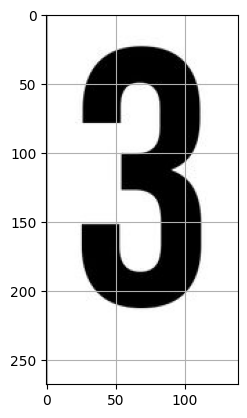

In [76]:
import matplotlib.pyplot as plt

idx = 3
img = cropped_images[idx]                  # image at index
plt.imshow(img, cmap=plt.cm.gray_r) # actutal BG is black (invert)
#plt.imshow(img, cmap=plt.cm.gray)  

plt.grid() 
plt.show()

## Sorting (การเรียงลำดับตัวอักษร)
เรียงลำดับตัวอักษรในแต่ละบรรทัดจากซ้ายไปขวา:

In [ ]:
# เรียงตัวอักษรตาม y (บรรทัด) ก่อน แล้วตาม x (ในบรรทัด)
#characters = sorted(characters, key=lambda c: (c[0]))
sorted_letters = []
for i, characters_in_line in enumerate(line_of_characters):
    sorted_letters.extend(sorted(characters_in_line, key=lambda c: (c[0])))

# ตัดภาพและเก็บในรูปแบบอาร์เรย์
cropped_images = []
for (x, y, w, h) in sorted_letters:
    cropped_image = image[y:y+h, x:x+w]  # ตัดภาพจากกรอบ
    cropped_images.append(cropped_image)  # เก็บภาพในรายการ

# แสดงผลจำนวนตัวอักษรและขนาดของ cropped images
print(f"จำนวนตัวอักษรที่ตรวจจับได้: {len(cropped_images)}")
for i, img in enumerate(cropped_images):
    #print(f"ตัวอักษรที่ {i+1}: ขนาดภาพ {img.shape}")
    print(f"ตัวอักษรที่ {i+1}: x,y,w,h {sorted_letters[i]}")

จำนวนตัวอักษรที่ตรวจจับได้: 10
ตัวอักษรที่ 1: x,y,w,h (9, 0, 123, 249)
ตัวอักษรที่ 2: x,y,w,h (174, 0, 84, 248)
ตัวอักษรที่ 3: x,y,w,h (306, 0, 121, 248)
ตัวอักษรที่ 4: x,y,w,h (452, 0, 121, 249)
ตัวอักษรที่ 5: x,y,w,h (592, 0, 137, 248)
ตัวอักษรที่ 6: x,y,w,h (11, 305, 121, 248)
ตัวอักษรที่ 7: x,y,w,h (157, 302, 123, 251)
ตัวอักษรที่ 8: x,y,w,h (304, 305, 122, 248)
ตัวอักษรที่ 9: x,y,w,h (449, 302, 127, 251)
ตัวอักษรที่ 10: x,y,w,h (598, 302, 123, 251)


### Visualization หลังเรียงลำดับ

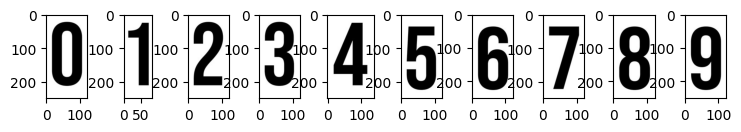

In [78]:
def visual_multi(i):
    nplots = len(cropped_images)
    fig = plt.figure(figsize=(9, 5))
    for j in range(nplots):
        plt.subplot(4, 10, j+1)
        plt.imshow(cropped_images[i+j], cmap=plt.cm.gray_r)
        #plt.title(y_train[i+j])
    
    plt.show()
visual_multi(0) # ตัวเริ่มจากเลขอะไร

## Predict
ส่งให้โมเดลทำนาย:

In [79]:
from tensorflow.keras.models import load_model

model = load_model('model/numrals_model.h5') # Load model
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [83]:
from tensorflow.image import rgb_to_grayscale
from tensorflow.image import resize
import numpy as np

cropped_characters = []

for img in cropped_images:

    # ตัดตัวอักษร
    #cropped_char = image[y:y+h, x:x+w]
    #cropped_characters.append(cropped_char)

    # ตัวอย่างการใช้โมเดลทำนาย
    resized_char = cv2.resize(img, (32, 32))  # Resize ให้ตรงกับ input ของโมเดล

    # ตรวจสอบว่าภาพเป็น RGB หรือไม่
    if resized_char.shape[-1] == 3:  # ถ้าเป็นภาพสี
        grayscale_image = rgb_to_grayscale(resized_char)
    else:
        grayscale_image = resized_char[..., np.newaxis]  # เพิ่มแกนช่องสี

    normalized_char = grayscale_image / 255  # Normalize

    #input_char = np.expand_dims(normalized_char, axis=-1)  # เพิ่ม Batch และ Channel Dimension
    input_char = np.expand_dims(normalized_char, axis=0)

    prediction = model.predict(input_char)
    predicted_label = np.argmax(prediction)
    confidence = np.max(prediction) * 100
    #print(f"Predicted: {predicted_label} | {confidence.round(2)} %")
    print(f"Predicted: {predicted_label} | {prediction.round(2)} %")

1/1 [==============================] - 0s 16ms/step
Predicted: 0 | [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] %
1/1 [==============================] - 0s 18ms/step
Predicted: 3 | [[0.   0.12 0.01 0.72 0.   0.   0.   0.15 0.   0.  ]] %
1/1 [==============================] - 0s 15ms/step
Predicted: 2 | [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]] %
1/1 [==============================] - 0s 16ms/step
Predicted: 3 | [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]] %
1/1 [==============================] - 0s 15ms/step
Predicted: 4 | [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] %
1/1 [==============================] - 0s 17ms/step
Predicted: 5 | [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]] %
1/1 [==============================] - 0s 17ms/step
Predicted: 6 | [[0.08 0.   0.   0.   0.   0.01 0.66 0.   0.25 0.  ]] %
1/1 [==============================] - 0s 16ms/step
Predicted: 7 | [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]] %
1/1 [==============================] - 0s 15ms/step
Predicted: 0 | [[0.97 0.   0.   0.   0.   0.   0.   0.   0.03 0.  ]] %
1/1 [========

In [81]:
for (x, y, w, h) in characters:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

cv2.imshow("Detected Characters", image)
cv2.waitKey(0)
cv2.destroyAllWindows()